In [1]:
import os, math
import keras

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Input, BatchNormalization
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statistics import pstdev, mean
from tensorflow.keras.models import load_model
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split, KFold
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
# first clean the ohio540_training.txt file

# Data inspection

# Define the file path
file_path = r'C:\Users\19176\Desktop\Ohio Data Set\data\new_training_folder\ohio540_Training.txt'

# Assuming the text file is comma-delimited (or use the appropriate delimiter)
dataFrame = pd.read_csv(file_path, delimiter=',')  # Adjust delimiter as needed

# Display the first few rows of the DataFrame
dataFrame.head()

,Time,CGM,basal_insulin,bolus_insulin,CHO,sleep,work,stressors,hypo_event,illness,...,gfm,ifm,gxi,gxc,isHyper,hour_of_day,SR,DR,exercise_ob_1st,exercise_ob_2nd
0,19-May-2027 11:35:00,76.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0,11,-5.308751,-5.308751,0,0
1,19-May-2027 11:40:00,72.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0,11,-6.865574,-6.865574,0,0
2,19-May-2027 11:45:00,68.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0,11,-8.726623,-8.726623,0,0
3,19-May-2027 11:50:00,65.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0,11,-10.351443,-10.351443,0,0
4,19-May-2027 11:55:00,63.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.0,1.0,1.0,0,11,-11.557186,-11.557186,0,0


In [3]:
# Display the shape/size of the data
dataFrame.shape

(13109, 43)

In [4]:
# Display first 100 values of the data
dataFrame.head(100)

,Time,CGM,basal_insulin,bolus_insulin,CHO,sleep,work,stressors,hypo_event,illness,...,gfm,ifm,gxi,gxc,isHyper,hour_of_day,SR,DR,exercise_ob_1st,exercise_ob_2nd
0,19-May-2027 11:35:00,76.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.000000,1.000000,1.000000,0,11,-5.308751,-5.308751,0,0
1,19-May-2027 11:40:00,72.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.000000,1.000000,1.000000,0,11,-6.865574,-6.865574,0,0
2,19-May-2027 11:45:00,68.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.000000,1.000000,1.000000,0,11,-8.726623,-8.726623,0,0
3,19-May-2027 11:50:00,65.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.000000,1.000000,1.000000,0,11,-10.351443,-10.351443,0,0
4,19-May-2027 11:55:00,63.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.000000,1.000000,1.000000,0,11,-11.557186,-11.557186,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,19-May-2027 19:30:00,97.0,0.006667,0.0,0.0,0,0,0,0,0,...,0.0,-0.095476,0.577611,0.974630,0,19,-0.762778,-0.760094,0,0
96,19-May-2027 19:35:00,97.0,0.006667,0.0,0.0,0,0,0,0,0,...,0.0,-0.134757,0.606273,0.975348,0,19,-0.762778,-0.760224,0,0
97,19-May-2027 19:40:00,98.0,0.006667,0.0,0.0,0,0,0,0,0,...,0.0,-0.172915,0.634650,0.976068,0,19,-0.661105,-0.657719,0,0
98,19-May-2027 19:45:00,97.0,0.006667,0.0,0.0,0,0,0,0,0,...,0.0,-0.209821,0.662600,0.976719,0,19,-0.762778,-0.760554,0,0


In [5]:
# Display last 100 values of the data
dataFrame.tail(100)

,Time,CGM,basal_insulin,bolus_insulin,CHO,sleep,work,stressors,hypo_event,illness,...,gfm,ifm,gxi,gxc,isHyper,hour_of_day,SR,DR,exercise_ob_1st,exercise_ob_2nd
13009,03-Jul-2027 15:40:00,149.0,0.006667,0.0,0.0,0,0,0,0,0,...,0.0,0.090515,0.929486,0.932518,1,15,2.752638,3.083505,0,0
13010,03-Jul-2027 15:45:00,155.0,0.006667,0.0,0.0,0,0,0,0,0,...,0.0,0.049442,0.933765,0.929041,1,15,3.583351,4.140886,0,0
13011,03-Jul-2027 15:50:00,162.0,0.006667,0.0,0.0,0,0,0,0,0,...,0.0,0.009360,0.942148,0.925616,1,15,4.643251,5.585150,0,0
13012,03-Jul-2027 15:55:00,165.0,0.006667,0.0,0.0,0,0,0,0,0,...,0.0,-0.029554,0.947919,0.922825,1,15,5.124111,6.234584,0,0
13013,03-Jul-2027 16:00:00,170.0,0.006667,0.0,0.0,0,0,0,0,0,...,0.0,-0.067166,0.950765,0.920740,1,16,5.957404,7.443746,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13104,03-Jul-2027 23:35:00,255.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.988959,0.623749,0.485603,1,23,23.570510,23.278134,0,0
13105,03-Jul-2027 23:40:00,258.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.933065,0.617617,0.481498,1,23,24.253772,24.337832,0,0
13106,03-Jul-2027 23:45:00,258.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.878530,0.612956,0.479318,1,23,24.253772,24.333708,0,0
13107,03-Jul-2027 23:50:00,257.0,0.013333,0.0,0.0,0,0,0,0,0,...,0.0,0.825640,0.608684,0.477758,1,23,24.025808,23.976385,0,0


In [6]:
# Check for missing values in each column
dataFrame.isnull().sum()

Time                         0
CGM                       1072
basal_insulin                0
bolus_insulin                0
CHO                          0
sleep                        0
work                         0
stressors                    0
hypo_event                   0
illness                      0
exercise                     0
basis_gsr                 6983
basis_skin_temperature    7031
acceleration              6983
is_breakfast                 0
is_lunch                     0
is_dinner                    0
is_hypotreatment             0
is_snack                     0
der                       1228
slope                     1384
t_h180                       0
t_h250                       0
pce                          0
COB                          0
pie                          0
IOB                          0
ic                           0
ic_pe                        0
ic_OB                        0
ic_w_bolus                   0
icob                         0
dcob    

In [7]:
# Get a concise summary of the DataFrame
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13109 entries, 0 to 13108
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    13109 non-null  object 
 1   CGM                     12037 non-null  float64
 2   basal_insulin           13109 non-null  float64
 3   bolus_insulin           13109 non-null  float64
 4   CHO                     13109 non-null  float64
 5   sleep                   13109 non-null  int64  
 6   work                    13109 non-null  int64  
 7   stressors               13109 non-null  int64  
 8   hypo_event              13109 non-null  int64  
 9   illness                 13109 non-null  int64  
 10  exercise                13109 non-null  int64  
 11  basis_gsr               6126 non-null   float64
 12  basis_skin_temperature  6078 non-null   float64
 13  acceleration            6126 non-null   float64
 14  is_breakfast            13109 non-null

In [8]:
# Generate descriptive statistics
dataFrame.describe()

,CGM,basal_insulin,bolus_insulin,CHO,sleep,work,stressors,hypo_event,illness,exercise,...,gfm,ifm,gxi,gxc,isHyper,hour_of_day,SR,DR,exercise_ob_1st,exercise_ob_2nd
count,12037.000000,13109.000000,13109.000000,13109.000000,13109.000000,13109.0,13109.0,13109.0,13109.0,13109.0,...,13109.000000,13109.000000,11103.000000,11103.000000,13109.000000,13109.000000,13109.000000,11881.000000,13109.0,13109.0
mean,137.187422,0.007776,0.018722,0.065909,0.032344,0.0,0.0,0.0,0.0,0.0,...,33.242134,0.004072,0.800705,0.822175,0.502098,11.565718,2.535919,2.876098,0.0,0.0
std,55.043333,0.005393,0.145955,0.985049,0.176919,0.0,0.0,0.0,0.0,0.0,...,88.225896,0.771098,0.158223,0.160228,0.500015,6.920825,8.874573,17.118590,0.0,0.0
min,40.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,-0.972692,0.205065,0.208899,0.000000,0.000000,-36.417547,-127.461405,0.0,0.0
25%,94.000000,0.006667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,-0.633658,0.703557,0.734366,0.000000,6.000000,-0.872865,-1.199675,0.0,0.0
50%,127.000000,0.006667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,-0.213396,0.841455,0.876171,1.000000,12.000000,0.183709,0.511157,0.0,0.0
75%,171.000000,0.006667,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,4.336993,0.415514,0.927100,0.948993,1.000000,18.000000,5.287674,6.532015,0.0,0.0
max,369.000000,0.035000,2.280000,20.000000,1.000000,0.0,0.0,0.0,0.0,0.0,...,681.468437,3.175987,1.000000,1.000000,1.000000,23.000000,49.959069,115.662754,0.0,0.0


In [9]:
# Get unique values in the 'Time' column
dataFrame['Time'].unique()

array(['19-May-2027 11:35:00', '19-May-2027 11:40:00',
       '19-May-2027 11:45:00', ..., '03-Jul-2027 23:45:00',
       '03-Jul-2027 23:50:00', '03-Jul-2027 23:55:00'], dtype=object)

In [10]:
# Check for missing values and return a DataFrame of boolean values
dataFrame.isna().sum()

Time                         0
CGM                       1072
basal_insulin                0
bolus_insulin                0
CHO                          0
sleep                        0
work                         0
stressors                    0
hypo_event                   0
illness                      0
exercise                     0
basis_gsr                 6983
basis_skin_temperature    7031
acceleration              6983
is_breakfast                 0
is_lunch                     0
is_dinner                    0
is_hypotreatment             0
is_snack                     0
der                       1228
slope                     1384
t_h180                       0
t_h250                       0
pce                          0
COB                          0
pie                          0
IOB                          0
ic                           0
ic_pe                        0
ic_OB                        0
ic_w_bolus                   0
icob                         0
dcob    

In [11]:
# Get only necessary columns
glucoseTime = dataFrame[['Time', 'CGM']]

glucoseTime.head()

,Time,CGM
0,19-May-2027 11:35:00,76.0
1,19-May-2027 11:40:00,72.0
2,19-May-2027 11:45:00,68.0
3,19-May-2027 11:50:00,65.0
4,19-May-2027 11:55:00,63.0


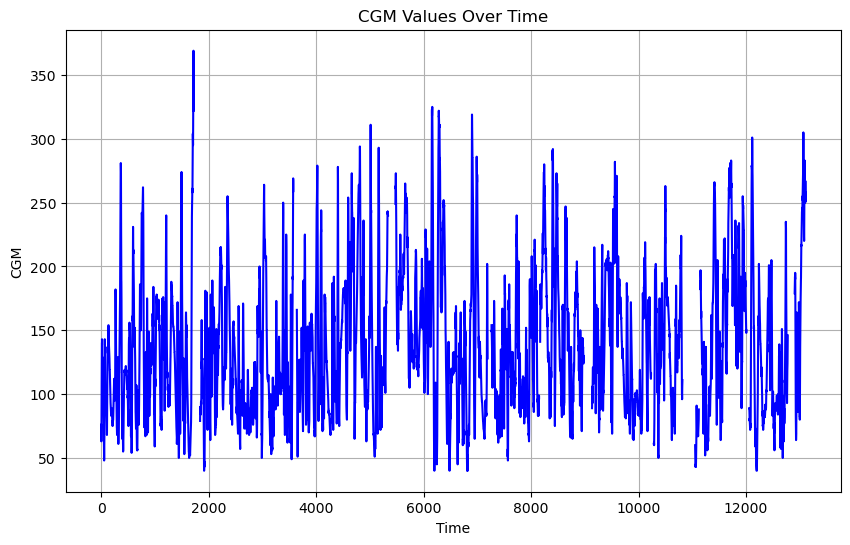

In [12]:
#  Plot CGM

# Assuming 'dataFrame' is your original DataFrame
# dataFrame = pd.DataFrame({'Time': [1, 2, 3], 'CGM': [100, 120, 110]})  # Replace with your actual data
# glucoseTime = dataFrame[['Time', 'CGM']]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(glucoseTime.index, glucoseTime.CGM, color='b')
plt.title('CGM Values Over Time')
plt.xlabel('Time')
plt.ylabel('CGM')
plt.grid(True)
plt.show()

In [13]:
# Resample Data

In [14]:
glucoseTime.shape

(13109, 2)

In [15]:
glucoseTime.columns

Index(['Time', 'CGM'], dtype='object')

In [16]:
glucoseTime.head()

,Time,CGM
0,19-May-2027 11:35:00,76.0
1,19-May-2027 11:40:00,72.0
2,19-May-2027 11:45:00,68.0
3,19-May-2027 11:50:00,65.0
4,19-May-2027 11:55:00,63.0


In [17]:
# Assuming glucoseTime is already defined as shown previously
glucoseTime = dataFrame[['Time', 'CGM']]
glucoseTime.shape

(13109, 2)

In [18]:
# Convert the 'Time' column to datetime format if it's not already
glucoseTime['Time'] = pd.to_datetime(glucoseTime['Time'], format='%d-%b-%Y %H:%M:%S')

glucoseTime.shape

c:\Users\19176\Documents\Anaconda\envs\tf_env\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(13109, 2)

In [19]:
dataFrame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13109 entries, 0 to 13108
Data columns (total 43 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Time                    13109 non-null  object 
 1   CGM                     12037 non-null  float64
 2   basal_insulin           13109 non-null  float64
 3   bolus_insulin           13109 non-null  float64
 4   CHO                     13109 non-null  float64
 5   sleep                   13109 non-null  int64  
 6   work                    13109 non-null  int64  
 7   stressors               13109 non-null  int64  
 8   hypo_event              13109 non-null  int64  
 9   illness                 13109 non-null  int64  
 10  exercise                13109 non-null  int64  
 11  basis_gsr               6126 non-null   float64
 12  basis_skin_temperature  6078 non-null   float64
 13  acceleration            6126 non-null   float64
 14  is_breakfast            13109 non-null

In [20]:
glucoseTime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13109 entries, 0 to 13108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Time    13109 non-null  datetime64[ns]
 1   CGM     12037 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 205.0 KB


In [21]:
glucoseTime.head()

,Time,CGM
0,2027-05-19 11:35:00,76.0
1,2027-05-19 11:40:00,72.0
2,2027-05-19 11:45:00,68.0
3,2027-05-19 11:50:00,65.0
4,2027-05-19 11:55:00,63.0


In [22]:
# Drop any rows with invalid datetime entries
#should be smaller value than original 13 x 2
glucoseTime.dropna(subset=['CGM'], inplace=True)
glucoseTime.shape

c:\Users\19176\Documents\Anaconda\envs\tf_env\lib\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(12037, 2)

In [23]:
print(glucoseTime.isnull().sum())

Time    0
CGM     0
dtype: int64


In [24]:
# Ensure the 'Time' column is set as the index
glucoseTime.set_index('Time', inplace=True)

# Resample the data to 30-minute frequency and calculate the mean
thirty_minute_resampled = glucoseTime.resample('30T').mean()

# Display the first few rows of the resampled data
print(thirty_minute_resampled.head())
print(thirty_minute_resampled.shape)

                            CGM
Time                           
2027-05-19 11:30:00   68.800000
2027-05-19 12:00:00   85.666667
2027-05-19 12:30:00  135.333333
2027-05-19 13:00:00  131.000000
2027-05-19 13:30:00  126.000000
(2185, 1)


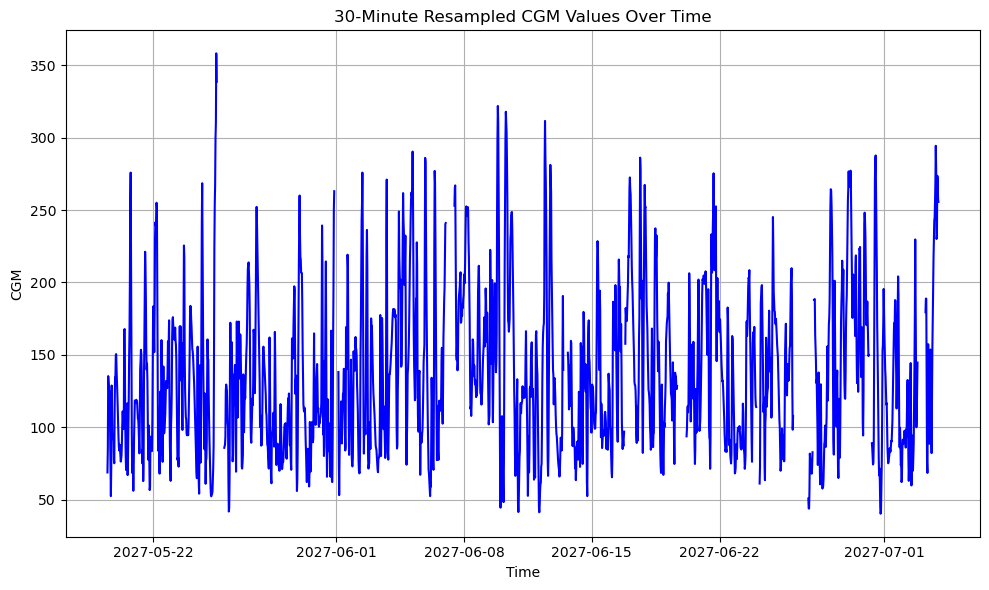

In [25]:
# Plotting the resampled data
plt.figure(figsize=(10, 6))
plt.plot(thirty_minute_resampled.index, thirty_minute_resampled['CGM'], color='b')
plt.title('30-Minute Resampled CGM Values Over Time')
plt.xlabel('Time')
plt.ylabel('CGM')
plt.grid(True)
plt.xticks(rotation=0)  # Change rotation to 0 for horizontal labels
plt.tight_layout()
plt.show()

In [26]:
# Change the input data

In [27]:
# Modify the Dataset
thirty_minute_resampled['CGM_predict'] = thirty_minute_resampled['CGM'].shift(-1)
thirty_minute_resampled.dropna(inplace=True)

thirty_minute_resampled.head()

,CGM,CGM_predict
Time,,
2027-05-19 11:30:00,68.800000,85.666667
2027-05-19 12:00:00,85.666667,135.333333
2027-05-19 12:30:00,135.333333,131.000000
2027-05-19 13:00:00,131.000000,126.000000
2027-05-19 13:30:00,126.000000,124.833333


In [28]:
# Save the data
thirty_minute_resampled.to_csv("cleaned_540_t1d.csv", encoding='utf-8', index=True, header=True)


In [29]:
file_path = r"C:\Users\19176\Desktop\Ohio Data Set\data\cleaned_540_t1d.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
print(df.head())

                  Time         CGM  CGM_predict
0  2027-05-19 11:30:00   68.800000    85.666667
1  2027-05-19 12:00:00   85.666667   135.333333
2  2027-05-19 12:30:00  135.333333   131.000000
3  2027-05-19 13:00:00  131.000000   126.000000
4  2027-05-19 13:30:00  126.000000   124.833333


In [30]:
# Read all 11 txt files in the new_testing_folder and clean them automatically
# Define the folder path
folder_path = r"C:\Users\19176\Desktop\Ohio Data Set\data\new_testing_folder"

# Loop through all text files in the folder
for file_name in os.listdir(folder_path):
    file_name = "\\"+file_name
    if file_name.endswith('.txt'): # Reorder structure to correct version above
            # print(folder_path + file_name)
            # Assuming the text file is comma-delimited (or use the appropriate delimiter)
            dataFrame = pd.read_csv(folder_path + file_name, delimiter=',')  # Adjust delimiter as needed
        # # Get only necessary columns: Time, CGM
            dataFrame = dataFrame[['Time', 'CGM']]

        # # Convert the 'Time' column to datetime format if it's not already
            dataFrame['Time'] = pd.to_datetime(dataFrame['Time'], format='%d-%b-%Y %H:%M:%S')

        # # Handle Null Values
        # # Drop any rows with invalid datetime entries
        # #should be smaller value than original 13 x 2
            dataFrame.dropna(subset=['CGM'], inplace=True)

        # # Resample the Data
        # # Ensure the 'Time' column is set as the index
            dataFrame.set_index('Time', inplace=True)
        # # Resample the data to 30-minute frequency and calculate the mean
            dataFrame = dataFrame.resample('30T').mean()

        # # Shift data to Get CGM_Predict
        # # Modify the Dataset
            dataFrame['CGM_predict'] = dataFrame['CGM'].shift(-1)
            dataFrame.dropna(inplace=True)

        # # Save the Cleaned Data
            
            id = file_name[5:8]
            # print(id)

            new_name = "cleaned_" + id + "_t1d.csv"


            dataFrame.to_csv(new_name, encoding='utf-8', index=True, header=True)
            print(dataFrame.head())

                            CGM  CGM_predict
Time                                        
2027-06-24 00:00:00  149.666667   130.500000
2027-06-24 00:30:00  130.500000   109.166667
2027-06-24 01:00:00  109.166667    94.500000
2027-06-24 01:30:00   94.500000    83.833333
2027-06-24 02:00:00   83.833333    75.333333
                            CGM  CGM_predict
Time                                        
2025-05-25 00:00:00  178.600000   162.666667
2025-05-25 00:30:00  162.666667   147.333333
2025-05-25 01:00:00  147.333333   123.500000
2025-05-25 01:30:00  123.500000   100.000000
2025-05-25 02:00:00  100.000000    84.333333
                            CGM  CGM_predict
Time                                        
2022-01-18 00:00:00  189.000000   210.166667
2022-01-18 00:30:00  210.166667   238.333333
2022-01-18 01:00:00  238.333333   257.500000
2022-01-18 01:30:00  257.500000   276.500000
2022-01-18 02:00:00  276.500000   293.500000
                            CGM  CGM_predict
Time      